In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import sys

### Carregando dados de numero de ligação por municípios

In [2]:
df_n_ligacoes = pd.read_csv('/home/breno/projects/sobre-rodas/data/raw/Ligações por Municipio.csv')
df_n_ligacoes = df_n_ligacoes.rename(columns={'COUNT(1)': 'NUM_LIGACOES'})
print(df_n_ligacoes.info())
print(df_n_ligacoes.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   CD_MUNICIPIO  203 non-null    int64
 1   NUM_LIGACOES  203 non-null    int64
dtypes: int64(2)
memory usage: 3.3 KB
None
   CD_MUNICIPIO  NUM_LIGACOES
0           511         17915
1           512         14080
2           522         54697
3           513          9027
4           722           625


### Carregando dados de Vistoria

In [4]:
df_vistorias = pd.read_csv('/home/breno/projects/sobre-rodas/data/raw/V_VISTORIAS_EXECUTADAS_202510141605.csv')
print(df_vistorias.info())
print(df_vistorias.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6105 entries, 0 to 6104
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   CD_MUNICIPIO                 6105 non-null   int64 
 1   SITUACAO_VISTORIA            6105 non-null   int64 
 2   SITUACAO_VISTORIA_DESCRICAO  6105 non-null   object
 3   DATA_EXECUCAO                6105 non-null   object
dtypes: int64(2), object(2)
memory usage: 190.9+ KB
None
   CD_MUNICIPIO  SITUACAO_VISTORIA SITUACAO_VISTORIA_DESCRICAO  \
0           571                  3                    NÃO APTO   
1           571                  3                    NÃO APTO   
2           571                  3                    NÃO APTO   
3           571                  3                    NÃO APTO   
4           571                  3                    NÃO APTO   

             DATA_EXECUCAO  
0  2024-07-02 11:13:17.000  
1  2024-07-02 09:31:11.000  
2  2024-12-

### Carregando dados de municípios

In [5]:
df_municipios = pd.read_csv('/home/breno/projects/sobre-rodas/data/raw/ORGAO_EMPRESA_202510141615.csv')
df_municipios = df_municipios.rename(columns={'CD_ORGAO_EMPRESA': 'CD_MUNICIPIO', 'NM_ORGAO_EMPRESA': 'NM_MUNICIPIO'})
print(df_municipios.info())
print(df_municipios.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CD_MUNICIPIO  473 non-null    int64 
 1   NM_MUNICIPIO  473 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.5+ KB
None
   CD_MUNICIPIO        NM_MUNICIPIO
0             1              MATRIZ
1             2              ITAJAÍ
2             3  BALNEÁRIO CAMBORIU
3             4       FLORIANÓPOLIS
4             5             TUBARÃO


### Calculando vistorias por ligação

In [6]:
# 1. Calcular NUM_VISTORIAS: Agrupa df_vistorias por município e conta o número de vistorias.
df_num_vistorias = (
    df_vistorias.groupby('CD_MUNICIPIO')
    .size()
    .reset_index(name='NUM_VISTORIAS')
)

# 2. Renomear coluna em df_n_ligacoes: Altera 'NOME_LIGACOES' para 'NUM_LIGACOES'.
df_n_ligacoes_renomeado = df_n_ligacoes.rename(columns={'NOME_LIGACOES': 'NUM_LIGACOES'})

# 3. Merge dos DataFrames: Junta df_municipios, df_n_ligacoes e df_num_vistorias
df_novo = df_municipios.merge(
    df_n_ligacoes_renomeado[['CD_MUNICIPIO', 'NUM_LIGACOES']],
    on='CD_MUNICIPIO',
    how='left'
)
df_novo = df_novo.merge(
    df_num_vistorias,
    on='CD_MUNICIPIO',
    how='left'
)

# 4. Tratar valores ausentes (NaN) com 0 para as colunas de cálculo
df_novo['NUM_LIGACOES'] = df_novo['NUM_LIGACOES'].fillna(0).astype(int)
df_novo['NUM_VISTORIAS'] = df_novo['NUM_VISTORIAS'].fillna(0).astype(int)

# 5. FILTRAGEM: Manter apenas os municípios onde NUM_VISTORIAS é maior que 0.
df_novo = df_novo[df_novo['NUM_VISTORIAS'] > 0]

# 6. Calcular VISTORIAS_POR_LIGACAOES, tratando a divisão por zero.
df_novo['VISTORIAS_POR_LIGACAOES'] = np.where(
    df_novo['NUM_LIGACOES'] != 0,
    df_novo['NUM_VISTORIAS'] / df_novo['NUM_LIGACOES'],
    0.0
)

# 7. Selecionar e ordenar as colunas finais
df_vistorias_por_ligacao = df_novo[['CD_MUNICIPIO', 'NM_MUNICIPIO', 'NUM_LIGACOES', 'NUM_VISTORIAS', 'VISTORIAS_POR_LIGACAOES']]

df_vistorias_por_ligacao

,CD_MUNICIPIO,NM_MUNICIPIO,NUM_LIGACOES,NUM_VISTORIAS,VISTORIAS_POR_LIGACAOES
247,524,MONDAÍ,2800,1657,0.591786
255,532,AGUA DOCE,1570,324,0.206369
288,571,DESCANSO,2131,1524,0.715157
312,599,ITAIÓPOLIS,5745,7,0.001218
325,615,LUIZ ALVES,1705,2,0.001173
327,617,MAJOR VIEIRA,1352,598,0.442308
331,621,MATOS COSTA,667,130,0.194903
397,701,OTACÍLIO COSTA,5993,1,0.000167
417,734,IPORÃ DO OESTE,2480,1378,0.555645
424,748,BELMONTE,593,6,0.010118


### Plotando vistorias por ligação

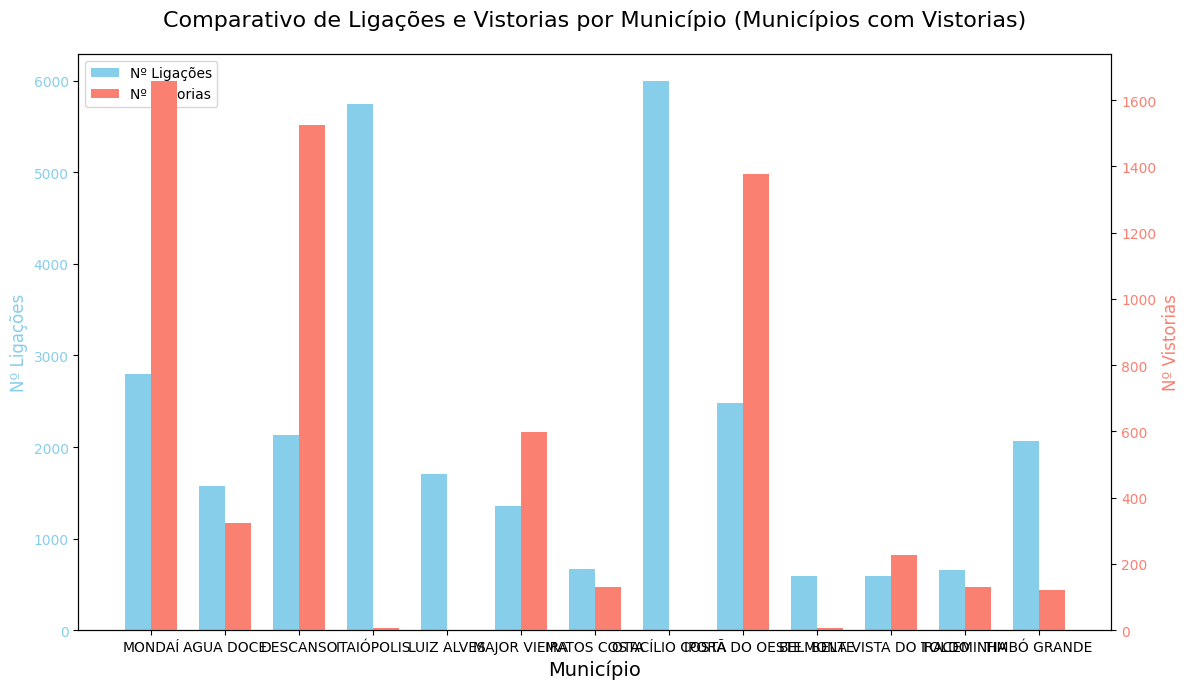

In [7]:
# --- Preparação dos Dados para o Gráfico ---

labels = df_vistorias_por_ligacao['NM_MUNICIPIO']
ligacoes = df_vistorias_por_ligacao['NUM_LIGACOES']
vistorias = df_vistorias_por_ligacao['NUM_VISTORIAS']

x = np.arange(len(labels))  # Localizações dos rótulos (0, 1, 2, ...)
width = 0.35  # Largura das barras

# --- Código de Plotagem (Gráfico de Barras Agrupadas com Eixo Duplo) ---

# Cria a figura e o eixo principal (ax1)
fig, ax1 = plt.subplots(figsize=(12, 7))

# 1. Plot NUM_LIGACOES no eixo primário (ax1)
rects1 = ax1.bar(x - width/2, ligacoes, width, label='Nº Ligações', color='skyblue')
ax1.set_ylabel('Nº Ligações', color='skyblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='skyblue')

# 2. Cria um eixo secundário (ax2) para NUM_VISTORIAS (twinx() faz isso)
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, vistorias, width, label='Nº Vistorias', color='salmon')
ax2.set_ylabel('Nº Vistorias', color='salmon', fontsize=12)
ax2.tick_params(axis='y', labelcolor='salmon')

# 3. Configurações gerais e rótulos
ax1.set_xlabel('Município', fontsize=14)
ax1.set_title('Comparativo de Ligações e Vistorias por Município (Municípios com Vistorias)', fontsize=16, pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=0, ha='center', fontsize=10) # Rótulos dos municípios no eixo X

# 4. Combina as legendas de ambos os eixos
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

# Ajusta o layout para evitar sobreposição
fig.tight_layout() 

# Mostra o gráfico (ou salva)
plt.show() 
# plt.savefig('ligacoes_vs_vistorias_dual_axis.png')

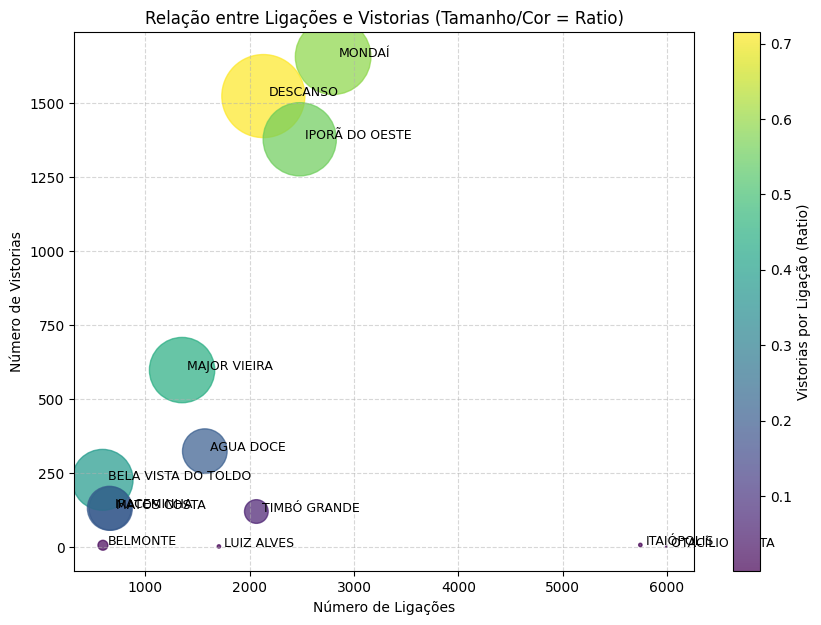

In [8]:
# Usando o ratio para definir a cor ou o tamanho dos pontos
ratio_sizes = df_vistorias_por_ligacao['VISTORIAS_POR_LIGACAOES'] * 5000 # Escala para melhor visualização

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    df_vistorias_por_ligacao['NUM_LIGACOES'],
    df_vistorias_por_ligacao['NUM_VISTORIAS'],
    s=ratio_sizes, # Tamanho do ponto baseado no ratio
    c=df_vistorias_por_ligacao['VISTORIAS_POR_LIGACAOES'], # Cor do ponto baseado no ratio
    cmap='viridis',
    alpha=0.7
)

# Adiciona rótulos para identificar os municípios
for i, row in df_vistorias_por_ligacao.iterrows():
    plt.annotate(
        row['NM_MUNICIPIO'], 
        (row['NUM_LIGACOES'] + 50, row['NUM_VISTORIAS']), # Ajuste a posição para não sobrepor
        fontsize=9
    )

plt.xlabel('Número de Ligações')
plt.ylabel('Número de Vistorias')
plt.title('Relação entre Ligações e Vistorias (Tamanho/Cor = Ratio)')
plt.colorbar(scatter, label='Vistorias por Ligação (Ratio)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Salvando Vistorias por ligação no banco de dados

In [11]:
DB_USER = "superset"
DB_PASSWORD = "superset"
DB_HOST = "superset.casan.com.br"
DB_PORT = "5432"
DB_NAME = "sobrerodas"
TABLE_NAME = "vistorias_ligacao"

# --- 2. Criar a Engine de Conexão (SQLAlchemy) ---

DATABASE_URL = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

try:
    engine = create_engine(DATABASE_URL)
    print("Engine de conexão criada com sucesso.")
    
    # --- 3. Gravar o DataFrame na Tabela do PostgreSQL ---
    
    df_vistorias_por_ligacao.to_sql(
        name=TABLE_NAME, 
        con=engine, 
        if_exists='replace', # Opções: 'fail', 'replace', 'append'
        index=False          # Não grava o índice do DataFrame como coluna
    )

    print(f"\nDataFrame gravado com sucesso na tabela '{TABLE_NAME}' no banco de dados '{DB_NAME}'.")

except ImportError:
    print("\nERRO: Certifique-se de que os pacotes 'pandas', 'sqlalchemy' e 'psycopg2' estão instalados.")
    print("Execute: pip install pandas sqlalchemy psycopg2")
except Exception as e:
    print(f"\nOCORREU UM ERRO ao tentar conectar ou gravar no banco de dados:")
    print(e)
    # Exibe a linha do erro, se possível
    exc_type, exc_obj, exc_tb = sys.exc_info()
    print(f"Linha do erro: {exc_tb.tb_lineno}")
finally:
    # É uma boa prática descartar a engine no final, embora não seja estritamente necessário 
    # se o script for encerrado logo em seguida.
    if 'engine' in locals():
        engine.dispose()

Engine de conexão criada com sucesso.

DataFrame gravado com sucesso na tabela 'vistorias_ligacao' no banco de dados 'sobrerodas'.


### Calculando aptos por ligação

In [22]:
df_vistorias['SITUACAO_VISTORIA_DESCRICAO'].unique()

array(['NÃO APTO', 'APTO COM RESTRIÇÃO', 'APTO', 'Pendente'], dtype=object)

In [13]:
# 1. Preparar df_n_ligacoes: Renomear a coluna de ligações
df_ligacoes = df_n_ligacoes.rename(columns={'NOME_LIGACOES': 'NUM_LIGACOES'})
df_ligacoes['CD_MUNICIPIO'] = df_ligacoes['CD_MUNICIPIO'].astype(int)


# 2. Filtrar df_vistorias e calcular NUM_VISTORIAS
situacoes_aceitas = ['APTO', 'APTO COM RESTRIÇÃO']

# Filtrar o dataframe de vistorias (apenas situações aceitas)
df_vistorias_filtradas = df_vistorias[
    df_vistorias['SITUACAO_VISTORIA_DESCRICAO'].isin(situacoes_aceitas)
].copy()

# Calcular o número de vistorias por município
df_num_vistorias = (
    df_vistorias_filtradas
    .groupby('CD_MUNICIPIO')
    .size()
    .reset_index(name='NUM_VISTORIAS')
)
df_num_vistorias['CD_MUNICIPIO'] = df_num_vistorias['CD_MUNICIPIO'].astype(int)


# 3. Unir os dataframes
# Merge 1: df_municipios com df_ligacoes (Left Join)
df_final = pd.merge(
    df_municipios[['CD_MUNICIPIO', 'NM_MUNICIPIO']],
    df_ligacoes[['CD_MUNICIPIO', 'NUM_LIGACOES']],
    on='CD_MUNICIPIO',
    how='left'
)

# Merge 2: Resultado com df_num_vistorias
# Nota: Usando 'left' join aqui, municípios sem vistorias válidas terão NUM_VISTORIAS = NaN
df_final = pd.merge(
    df_final,
    df_num_vistorias,
    on='CD_MUNICIPIO',
    how='left'
)

# 4. Tratar valores NaN
df_final['NUM_LIGACOES'] = df_final['NUM_LIGACOES'].fillna(0).astype(int)
# O NUM_VISTORIAS será tratado no próximo passo para filtrar, mas é bom preencher para o cálculo
df_final['NUM_VISTORIAS'] = df_final['NUM_VISTORIAS'].fillna(0).astype(int)


# 5. FILTRAR: Manter apenas os municípios onde NUM_VISTORIAS > 0
df_final_filtrado = df_final[df_final['NUM_VISTORIAS'] > 0].copy()


# 6. Calcular VISTORIAS_POR_LIGACAOES (no dataframe já filtrado)
df_final_filtrado['VISTORIAS_POR_LIGACOES'] = np.where(
    df_final_filtrado['NUM_LIGACOES'] != 0,
    np.divide(df_final_filtrado['NUM_VISTORIAS'], df_final_filtrado['NUM_LIGACOES']),
    0.0 # Define 0.0 onde NUM_LIGACOES é zero
)

# 7. Selecionar e reordenar as colunas finais
df_aptos_por_ligacao = df_final_filtrado[[
    'CD_MUNICIPIO', 
    'NM_MUNICIPIO', 
    'NUM_LIGACOES', 
    'NUM_VISTORIAS', 
    'VISTORIAS_POR_LIGACOES'
]]

# Exibir o DataFrame resultante
df_aptos_por_ligacao.head()

,CD_MUNICIPIO,NM_MUNICIPIO,NUM_LIGACOES,NUM_VISTORIAS,VISTORIAS_POR_LIGACOES
247,524,MONDAÍ,2800,956,0.341429
255,532,AGUA DOCE,1570,177,0.112739
288,571,DESCANSO,2131,1050,0.492726
312,599,ITAIÓPOLIS,5745,4,0.000696
325,615,LUIZ ALVES,1705,2,0.001173


### Plotando aptos por ligação

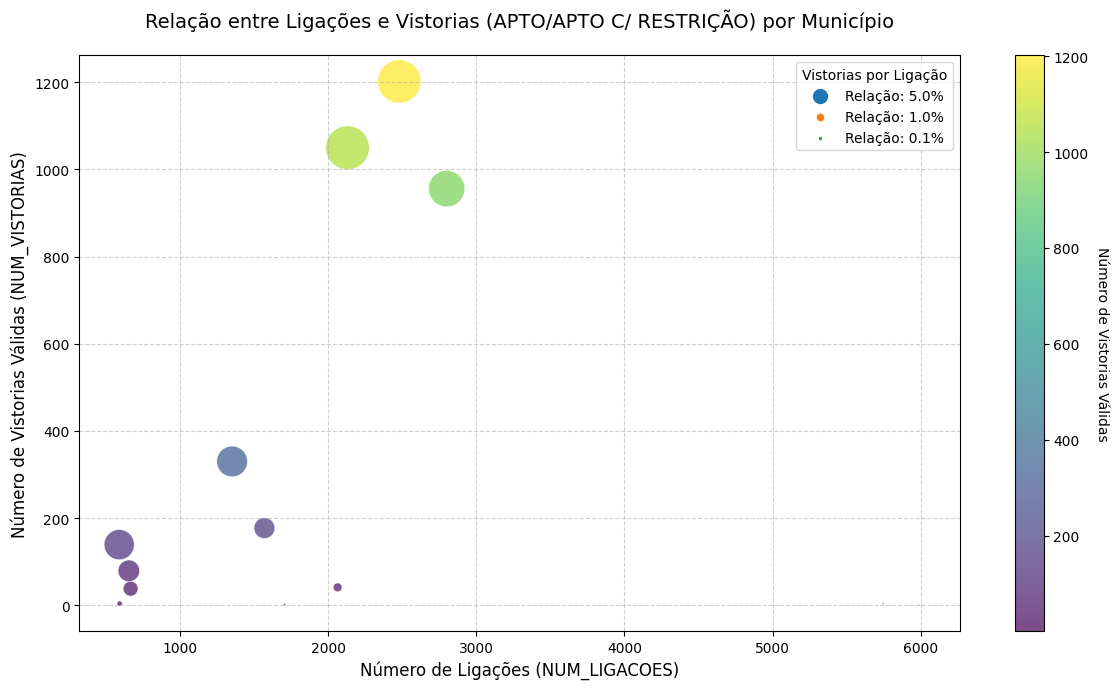

In [14]:
# Definindo as variáveis para o gráfico de dispersão
x_data = df_aptos_por_ligacao['NUM_LIGACOES']
y_data = df_aptos_por_ligacao['NUM_VISTORIAS']

# Usaremos a coluna VISTORIAS_POR_LIGACOES para definir o tamanho da bolha (s)
# Multiplicamos por um fator (ex: 2000) para tornar as bolhas visíveis e proporcionais
tamanho_bolha = df_aptos_por_ligacao['VISTORIAS_POR_LIGACOES'] * 2000 

# Para a cor, vamos usar o NUM_VISTORIAS
cores = df_aptos_por_ligacao['NUM_VISTORIAS']


# 1. Criação da figura e dos eixos
plt.figure(figsize=(12, 7))

# 2. Criação do gráfico de dispersão (scatter plot)
# Usamos a função scatter do matplotlib.pyplot
scatter = plt.scatter(
    x=x_data,
    y=y_data,
    s=tamanho_bolha,         # Tamanho da bolha
    c=cores,                 # Cor baseada no número de vistorias
    cmap='viridis',          # Mapa de cores (pode ser 'Reds', 'Blues', 'plasma', etc.)
    alpha=0.7,               # Transparência dos pontos
    edgecolors='w',          # Cor da borda do ponto (branco)
    linewidth=0.5
)

# 3. Personalização do gráfico
plt.title('Relação entre Ligações e Vistorias (APTO/APTO C/ RESTRIÇÃO) por Município', fontsize=14, pad=20)
plt.xlabel('Número de Ligações (NUM_LIGACOES)', fontsize=12)
plt.ylabel('Número de Vistorias Válidas (NUM_VISTORIAS)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Adicionar barra de cores (Colorbar) para interpretar a cor
cbar = plt.colorbar(scatter)
cbar.set_label('Número de Vistorias Válidas', rotation=270, labelpad=15)

# Adicionar legenda (handles) para o tamanho das bolhas
# Criar marcadores fictícios para a legenda de tamanho (opcional, mas útil)
lig_05 = 0.05 * 2000
lig_01 = 0.01 * 2000
lig_001 = 0.001 * 2000

plt.legend(
    handles=[
        plt.scatter([], [], s=lig_05, label='Relação: 5.0%'),
        plt.scatter([], [], s=lig_01, label='Relação: 1.0%'),
        plt.scatter([], [], s=lig_001, label='Relação: 0.1%')
    ],
    title="Vistorias por Ligação",
    loc='upper right',
    frameon=True
)

# 4. Exibir o gráfico
plt.tight_layout() # Ajusta automaticamente os parâmetros do subplot para que caibam na área da figura
plt.show()

### Gravando aptos por ligação no banco de dados

In [15]:
DB_USER = "superset"
DB_PASSWORD = "superset"
DB_HOST = "superset.casan.com.br"
DB_PORT = "5432"
DB_NAME = "sobrerodas"
TABLE_NAME = "aptos_ligacao"

# --- 2. Criar a Engine de Conexão (SQLAlchemy) ---

DATABASE_URL = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

try:
    engine = create_engine(DATABASE_URL)
    print("Engine de conexão criada com sucesso.")
    
    # --- 3. Gravar o DataFrame na Tabela do PostgreSQL ---
    
    df_aptos_por_ligacao.to_sql(
        name=TABLE_NAME, 
        con=engine, 
        if_exists='replace', # Opções: 'fail', 'replace', 'append'
        index=False          # Não grava o índice do DataFrame como coluna
    )

    print(f"\nDataFrame gravado com sucesso na tabela '{TABLE_NAME}' no banco de dados '{DB_NAME}'.")

except ImportError:
    print("\nERRO: Certifique-se de que os pacotes 'pandas', 'sqlalchemy' e 'psycopg2' estão instalados.")
    print("Execute: pip install pandas sqlalchemy psycopg2")
except Exception as e:
    print(f"\nOCORREU UM ERRO ao tentar conectar ou gravar no banco de dados:")
    print(e)
    # Exibe a linha do erro, se possível
    exc_type, exc_obj, exc_tb = sys.exc_info()
    print(f"Linha do erro: {exc_tb.tb_lineno}")
finally:
    # É uma boa prática descartar a engine no final, embora não seja estritamente necessário 
    # se o script for encerrado logo em seguida.
    if 'engine' in locals():
        engine.dispose()

Engine de conexão criada com sucesso.

DataFrame gravado com sucesso na tabela 'aptos_ligacao' no banco de dados 'sobrerodas'.
